In [299]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pyunicorn.timeseries import RecurrencePlot
import iberoSignalPro.preprocesa as ib
import ntwktools as nt

import logging
logging.basicConfig(level=logging.CRITICAL)

In [300]:
FILE_NAME = r"C:\Users\fercy\OneDrive\Escritorio\InternadoFMM\Pruebas%20BCI\SeñalesProcesadas10Hz2\PabloRoca\S2\10deTorquePre.csv"


#INPUT

selected_channels = [["C2", "C1", "FCz", "Cz", "Pz"],
                     ["Cz", "Oz", "C3", "FCz", "P3"],
                     ["C3", "FC4", "CP3", "P4"]]



#INPUT

#selected_channels = [["C3", "CP3", "C1", "Pz", "Oz", "C4", "CP4"],
#                       ["Oz", "C3", "P3", "FC4"],
#                      ["CP3", "P3", "C3", "C4", "C2", "P4"]]

#OUTPUT
#selected_channels = [["Cz", "C1", "C2", "P3"],
#                    ["FCz", "Oz", "P3", "CP4"],
#                    ["C1", "C2", "P4", "O2"]]

#BETE
#selected_channels = [["FC4", "Pz", "FCz", "C2"],
#                    ["Cz", "O2"],
#                    ["C2", "FC4", "CP3"]]

band = "mu"

if band == "mu":
    selected_channels = selected_channels[0]
elif band == "beta":
    selected_channels = selected_channels[1]
else:
    selected_channels = selected_channels[2]

(2377,)


(5, 2377)

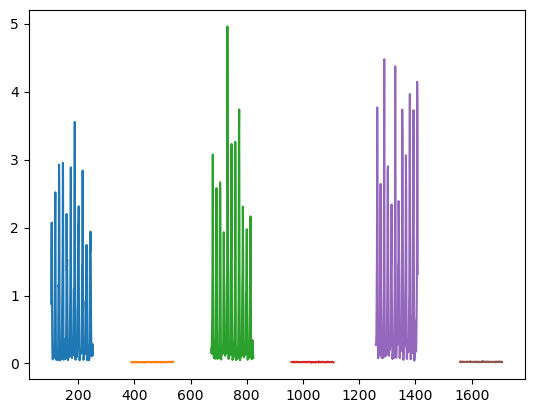

In [301]:
data = pd.read_csv(FILE_NAME)

act, rep = nt.obtener_win(data.EnvAnta, data.Binaria, siPlot = False)
act, rep = nt.selecciona_ventanas(act, rep, siPlot = True, signal = data.EnvAnta, win_len=15)

binary_signal = data["Binaria"]
selected_columns = [f"{band}_" + ch for ch in selected_channels]
subset = data[selected_columns]

# Reemplazar infs y nans con 0
subset = subset.replace([np.inf, -np.inf], np.nan).fillna(0)

# Convertir a NumPy array y transponer
data = np.array(subset).T
data.shape

In [302]:
from scipy.spatial import distance
import rqatools as rqt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [303]:
def get_Lmax(distance_vecindad):
    count = max_count = 0
    for val in distance_vecindad:
        if val == 1:
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count


In [304]:
from scipy.stats import entropy

def get_Lmax(distance_vecindad, min_length=10):
    lines = []
    count = 0
    for val in distance_vecindad:
        if val == 1:
            count += 1
        else:
            if count >= min_length:
                lines.append(count)
            count = 0
    if count >= min_length:
        lines.append(count)
    if len(lines) == 0:
        return 0
    _, counts = np.unique(lines, return_counts=True)
    return entropy(counts)


In [305]:
order = 5
recurrence_rate = [0]
distance_vecindad = []
lmax = []
lmax_1 = []

recurrence_rate_1 = [0]
distance_vecindad_1 = []

n_features = data.shape[0]
n_initi_samples = 5
init_data = np.zeros((n_initi_samples, n_features))

promedios = []

for i, row in enumerate(data.T):
    if i < n_initi_samples:
        init_data[i, :] = row
        if i == n_initi_samples - 1:
            gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
            gmm.fit(init_data)
            mus = gmm.means_
            sigmas = gmm.covariances_
            pis = gmm.weights_

    else:
        try:
            mus, sigmas, pis, gamma= rqt.EM_estimation(
                row, n_componentes=2, mus=mus, sigmas=sigmas, pis=pis, alpha=0.01
            )
        except:
            print("a")
        recurrence_rate, distance_vecindad = rqt.get_miniRR(
        row, mus[0], sigmas[0], alpha=7,
        recurrence_rate=recurrence_rate, 
        distance_vecindad=distance_vecindad, 
        order=order
        )
        
        recurrence_rate_1, distance_vecindad_1 = rqt.get_miniRR(
        row, mus[1], sigmas[1], alpha=1,
        recurrence_rate=recurrence_rate_1, 
        distance_vecindad=distance_vecindad_1, 
        order=order
        )
        lmax.append(get_Lmax(distance_vecindad))
        lmax_1.append(get_Lmax(distance_vecindad_1))
        
        promedios.append(mus)
        
recurrence_rate_1 = np.array(recurrence_rate_1)
recurrence_rate = np.array(recurrence_rate)

distance_vecindad = np.array(distance_vecindad)
distance_vecindad_1 = np.array(distance_vecindad_1)

lmax = np.array(lmax)
lmax_1 = np.array(lmax_1)



promedios = np.array(promedios)

c:\Users\fercy\miniconda3\envs\ibero\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



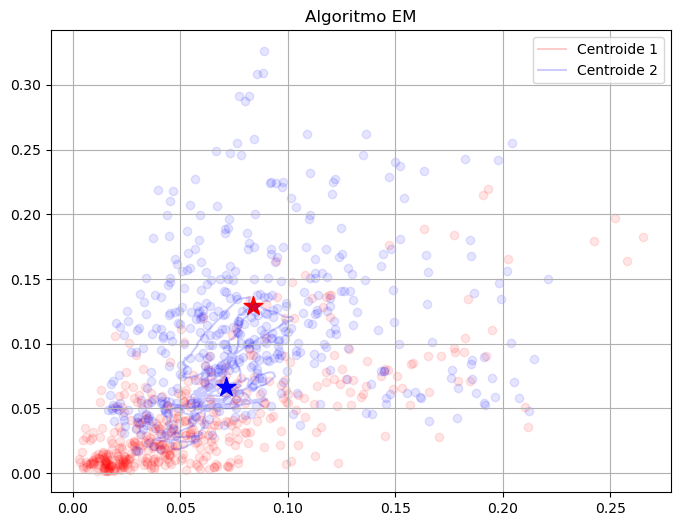

In [306]:
plt.figure(figsize=(8,6))
for actividad in act:
    plt.scatter(data[0, actividad[0]: actividad[1]], data[1, actividad[0]: actividad[1]], color  = "red", alpha=0.1)

for reposo in rep:
     plt.scatter(data[0,reposo[0]: reposo[1]], data[1, reposo[0]: reposo[1]], color  = "blue", alpha=0.1)

plt.plot(promedios[:, 0, 0], promedios[:, 0, 1], color='red', label='Centroide 1', alpha = 0.2)
plt.plot(promedios[:, 1, 0], promedios[:, 1, 1], color='blue', label='Centroide 2', alpha = 0.2)
plt.scatter(promedios[-1, 0, 0], promedios[-1, 0, 1], color='red', s=200, marker='*')
plt.scatter(promedios[-1, 1, 0], promedios[-1, 1, 1], color='blue', s=200, marker='*')
plt.legend()
plt.title('Algoritmo EM')
plt.grid(True)
plt.show()

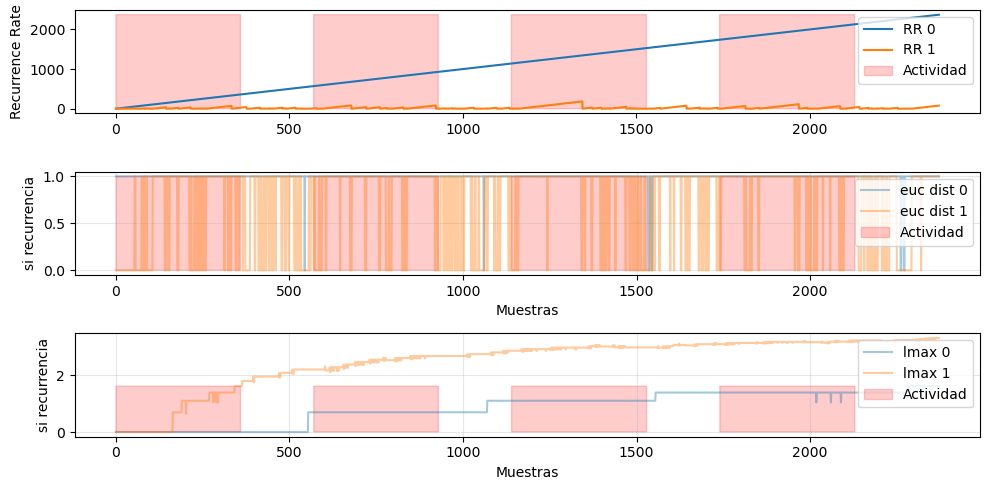

In [307]:
plt.figure(figsize = (10, 5))
#plt.plot(disntance_vecindad)

plt.subplot(3, 1, 1)

plt.plot(recurrence_rate, label = "RR 0")
plt.plot(recurrence_rate_1, label = "RR 1")


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    np.max([recurrence_rate_1, recurrence_rate]),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)

plt.ylabel("Recurrence Rate")
plt.legend(loc="upper right")
plt.subplot(3, 1, 2)

plt.plot(distance_vecindad, label = "euc dist 0", alpha = 0.4)
plt.plot(distance_vecindad_1, label = "euc dist 1", alpha = 0.4)


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    distance_vecindad.max(),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)


plt.xlabel("Muestras")
plt.ylabel("si recurrencia")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.subplot(3, 1, 3)

plt.plot(lmax, label = "lmax 0", alpha = 0.4)
plt.plot(lmax_1, label = "lmax 1", alpha = 0.4)


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    lmax.max(),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)


plt.xlabel("Muestras")
plt.ylabel("si recurrencia")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [308]:
order = 5
recurrence_rate = [0]
distance_vecindad = []

recurrence_rate_1 = [0]
distance_vecindad_1 = []

n_features = data.shape[0]
n_initi_samples = 5
init_data = np.zeros((n_initi_samples, n_features))

promedios = []
k = 2

for i, row in enumerate(data.T):
    if i < n_initi_samples:
        init_data[i, :] = row
        if i == n_initi_samples - 1:
            centroids = init_data[np.random.choice(init_data.shape[0], k, replace=False)]
    else:
        centroids= rqt.K_means_estimation(row, k=k, centroids=centroids, alpha=0.01)

        recurrence_rate, distance_vecindad = rqt.get_miniRR(
        row, centroids[0], 0.04, alpha=3,
        recurrence_rate=recurrence_rate, 
        distance_vecindad=distance_vecindad, 
        order=order
        )

        recurrence_rate_1, distance_vecindad_1 = rqt.get_miniRR(
        row, centroids[1], 0.04, alpha=3,
        recurrence_rate=recurrence_rate_1, 
        distance_vecindad=distance_vecindad_1, 
        order=order
        )

        promedios.append(centroids)
        
recurrence_rate_1 = np.array(recurrence_rate_1)
recurrence_rate = np.array(recurrence_rate)

distance_vecindad = np.array(distance_vecindad)
distance_vecindad_1 = np.array(distance_vecindad_1)


promedios = np.array(promedios)

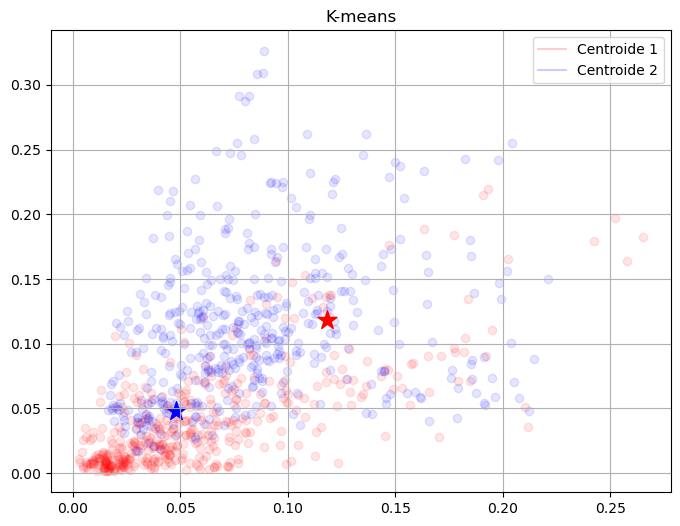

In [309]:
plt.figure(figsize=(8,6))
for actividad in act:
    plt.scatter(data[0, actividad[0]: actividad[1]], data[1, actividad[0]: actividad[1]], color  = "red", alpha=0.1)

for reposo in rep:
     plt.scatter(data[0,reposo[0]: reposo[1]], data[1, reposo[0]: reposo[1]], color  = "blue", alpha=0.1)

plt.plot(promedios[:, 0, 0], promedios[:, 0, 1], color='red', label='Centroide 1', alpha = 0.2)
plt.plot(promedios[:, 1, 0], promedios[:, 1, 1], color='blue', label='Centroide 2', alpha = 0.2)
plt.scatter(promedios[-1, 0, 0], promedios[-1, 0, 1], color='red', s=200, marker='*')
plt.scatter(promedios[-1, 1, 0], promedios[-1, 1, 1], color='blue', s=200, marker='*')
plt.legend()
plt.title('K-means')
plt.grid(True)
plt.show()

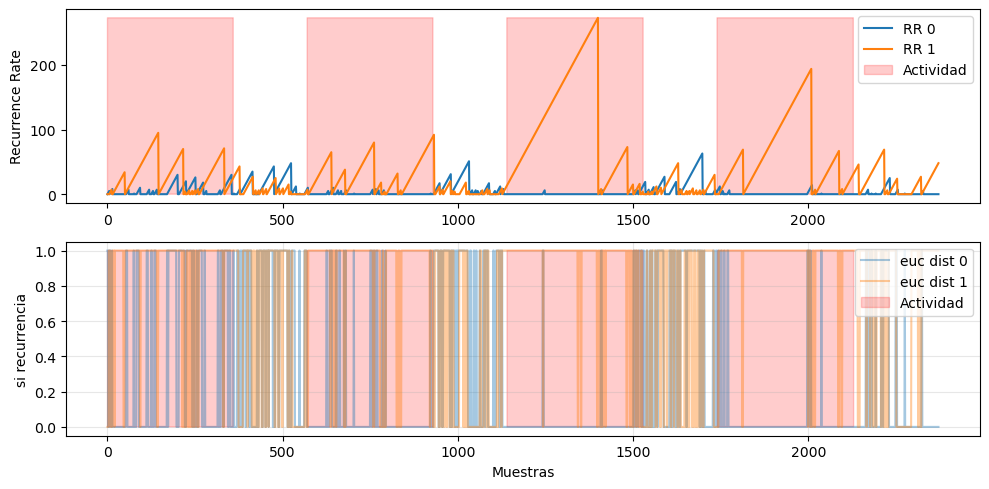

In [310]:
plt.figure(figsize = (10, 5))
#plt.plot(disntance_vecindad)

plt.subplot(2, 1, 1)

plt.plot(recurrence_rate, label = "RR 0")
plt.plot(recurrence_rate_1, label = "RR 1")


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    np.max([recurrence_rate_1, recurrence_rate]),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)

plt.ylabel("Recurrence Rate")
plt.legend(loc="upper right")
plt.subplot(2, 1, 2)

plt.plot(distance_vecindad, label = "euc dist 0", alpha = 0.4)
plt.plot(distance_vecindad_1, label = "euc dist 1", alpha = 0.4)


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    distance_vecindad.max(),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)


plt.xlabel("Muestras")
plt.ylabel("si recurrencia")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# SOM

In [311]:
order = 6
recurrence_rate = [0]
distance_vecindad = []

recurrence_rate_1 = [0]
distance_vecindad_1 = []

n_features = data.shape[0]
n_initi_samples = 5
init_data = np.zeros((n_initi_samples, n_features))

history_weights = []
k = 2

n_neurons = 5

weights = np.zeros((n_neurons, n_features))

weights[1] += 0.8


alpha_0 = 0.08
sigma_0 = 3.0
tau_alpha = 1000  # controla qué tan rápido decae alpha
tau_sigma = 1000  # controla qué tan rápido decae sigma

# Inicialización
#weights = np.random.rand(n_neurons, n_features)

for iteration, row in enumerate(data.T):
    
    # Actualizar alpha y sigma con decaimiento exponencial
    alpha = alpha_0 * np.exp(-iteration / tau_alpha)
    sigma = sigma_0 * np.exp(-iteration / tau_sigma)

    # Actualizar pesos del SOM
    weights = rqt.SOM_estimation(row, n_neurons=n_neurons, alpha=alpha, sigma=sigma, weights=weights)


    recurrence_rate, distance_vecindad = rqt.get_miniRR(
    row, weights[0], 0.07, alpha=2,
    recurrence_rate=recurrence_rate, 
    distance_vecindad=distance_vecindad, 
    order=order
    )

    recurrence_rate_1, distance_vecindad_1 = rqt.get_miniRR(
    row, weights[1], 0.07, alpha=2,
    recurrence_rate=recurrence_rate_1, 
    distance_vecindad=distance_vecindad_1, 
    order=order
    )

        
    history_weights.append(weights.copy())

    # Convertimos historia a array
history_weights = np.array(history_weights)  # shape: (steps, n_neurons, input_dim)

        
recurrence_rate_1 = np.array(recurrence_rate_1)
recurrence_rate = np.array(recurrence_rate)

distance_vecindad = np.array(distance_vecindad)
distance_vecindad_1 = np.array(distance_vecindad_1)




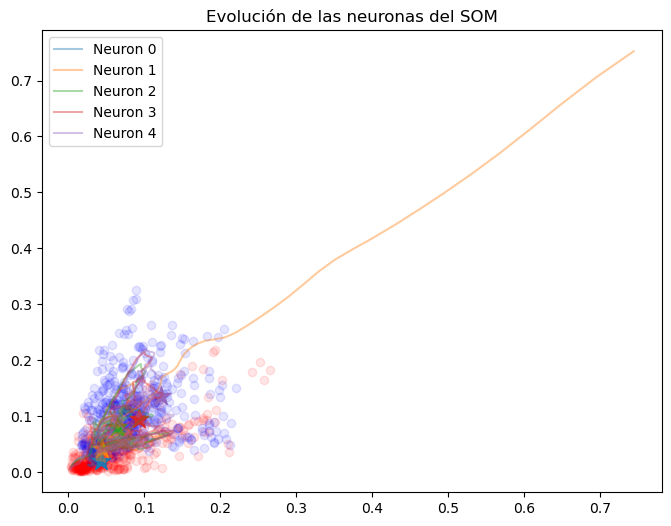

In [312]:
plt.figure(figsize = (8, 6))

for actividad in act:
    plt.scatter(data[0, actividad[0]: actividad[1]], data[1, actividad[0]: actividad[1]], color  = "red", alpha=0.1)

for reposo in rep:
     plt.scatter(data[0,reposo[0]: reposo[1]], data[1, reposo[0]: reposo[1]], color  = "blue", alpha=0.1)


for i in range(n_neurons):
    plt.plot(history_weights[:, i, 0], history_weights[:, i, 1], label=f'Neuron {i}', alpha = 0.4)
    plt.scatter(history_weights[-1, i, 0], history_weights[-1, i, 1], marker='*', s=200)

plt.title("Evolución de las neuronas del SOM")
plt.legend()
plt.grid(False)
plt.show()


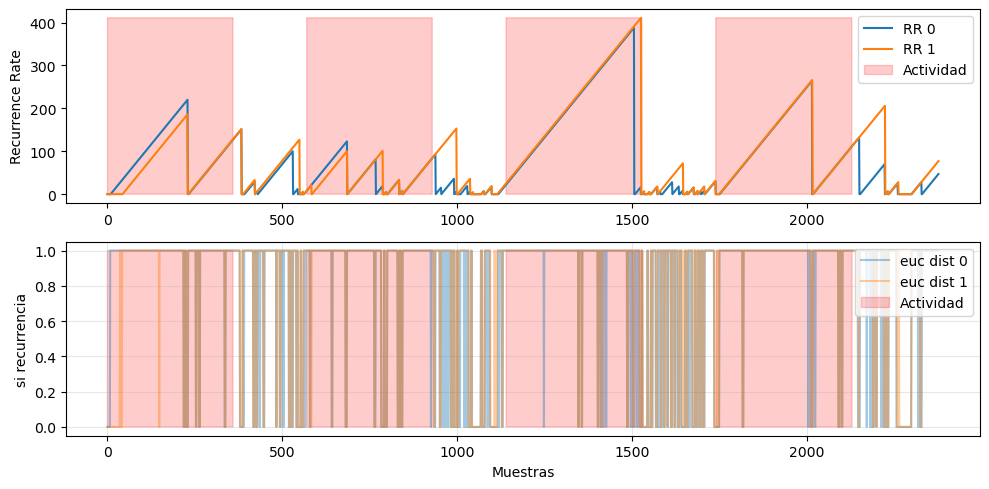

In [313]:
plt.figure(figsize = (10, 5))
#plt.plot(disntance_vecindad)

plt.subplot(2, 1, 1)

plt.plot(recurrence_rate, label = "RR 0")
plt.plot(recurrence_rate_1, label = "RR 1")


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    np.max([recurrence_rate_1, recurrence_rate]),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)

plt.ylabel("Recurrence Rate")
plt.legend(loc="upper right")
plt.subplot(2, 1, 2)

plt.plot(distance_vecindad, label = "euc dist 0", alpha = 0.4)
plt.plot(distance_vecindad_1, label = "euc dist 1", alpha = 0.4)


plt.fill_between(
    range(len(binary_signal)),
    0,  # desde cero
    distance_vecindad.max(),  # hasta el máximo de la señal
    where=binary_signal > 0.8,
    color='red',
    alpha=0.2,
    step='pre',
    label="Actividad"
)


plt.xlabel("Muestras")
plt.ylabel("si recurrencia")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

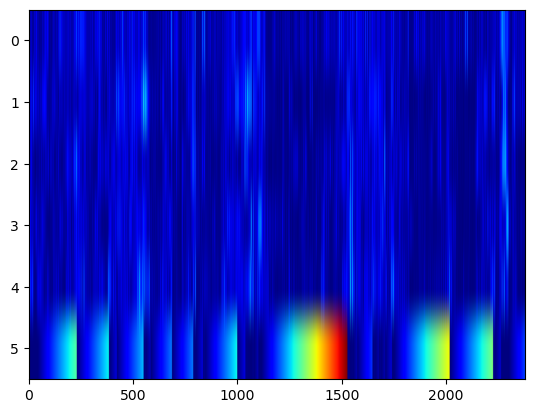

In [314]:
plt.imshow(np.concatenate([data, recurrence_rate_1[1:].reshape(1, recurrence_rate_1.shape[0] -1)/recurrence_rate_1.max()], axis = 0), aspect="auto", cmap="jet")

In [315]:
import plotly.graph_objects as go

fig = go.Figure()

# Datos de actividad (rojo)
for actividad in act:
    fig.add_trace(go.Scatter3d(
        x=data[0, actividad[0]:actividad[1]],
        y=data[1, actividad[0]:actividad[1]],
        z=data[2, actividad[0]:actividad[1]],
        mode='lines+markers',
        marker=dict(size=2, color='red', opacity=0.1),
        line=dict(width=0.5),
        name='Actividad'
    ))

# Datos de reposo (azul)
for reposo in rep:
    fig.add_trace(go.Scatter3d(
        x=data[0, reposo[0]:reposo[1]],
        y=data[1, reposo[0]:reposo[1]],
        z=data[2, reposo[0]:reposo[1]],
        mode='lines+markers',
        marker=dict(size=2, color='blue', opacity=0.3),
        line=dict(width=0.5),
        name='Reposo'
    ))

# Evolución de neuronas
for i in range(n_neurons):
    fig.add_trace(go.Scatter3d(
        x=history_weights[:, i, 0],
        y=history_weights[:, i, 1],
        z=history_weights[:, i, 2],
        mode='lines',
        line=dict(width=2),
        name=f'Neuron {i}'
    ))
    fig.add_trace(go.Scatter3d(
        x=[history_weights[-1, i, 0]],
        y=[history_weights[-1, i, 1]],
        z=[history_weights[-1, i, 2]],
        mode='markers',
        marker=dict(size=8, symbol='diamond', color='black'),
        showlegend=False
    ))

fig.update_layout(
    title='Evolución de las neuronas del SOM en 3D',
    scene=dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend=dict(itemsizing='constant'),
    template='plotly_white'
)

fig.show()
